In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_dir = 'H:\\FakeKasi'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [3]:
image_size = (128, 128)
batch_size = 4

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 133233 images belonging to 2 classes.
Found 38066 images belonging to 2 classes.
Found 19036 images belonging to 2 classes.


In [4]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=image_size + (3,))
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

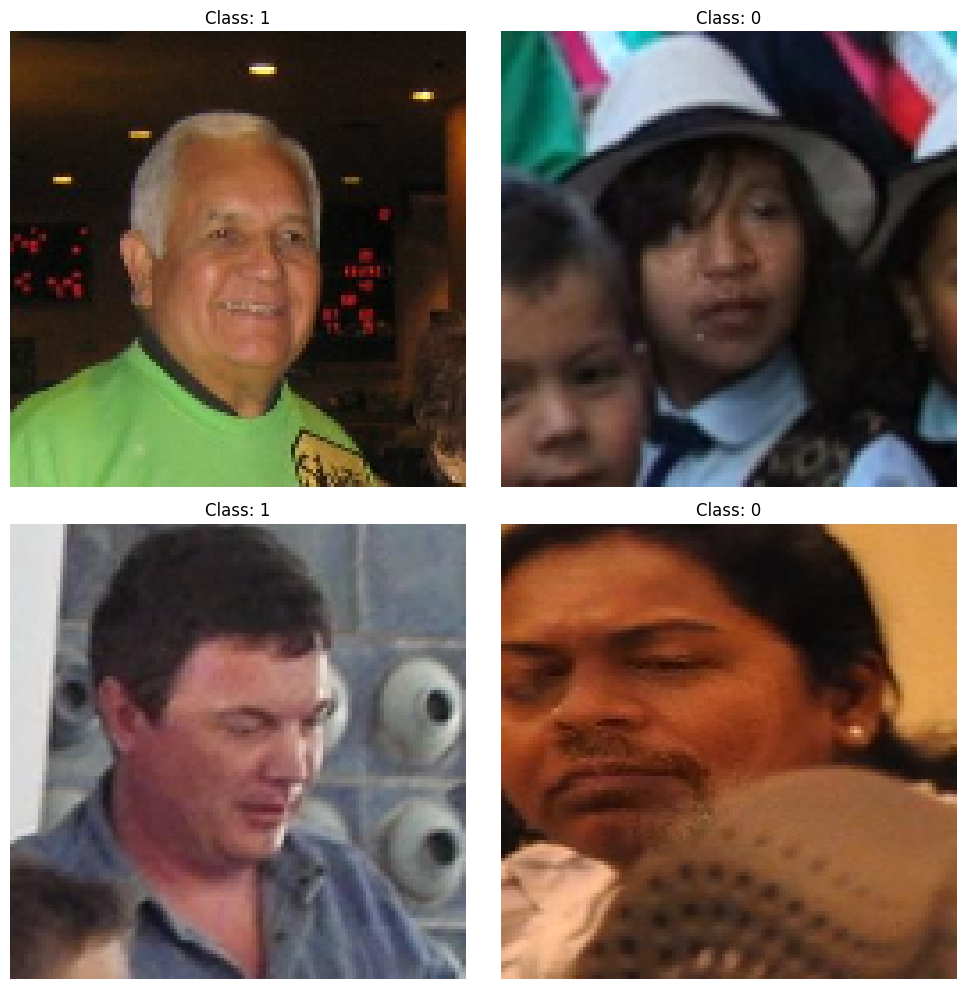

In [5]:
def plot_sample_images(generator):
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(min(4, len(x))):
        plt.subplot(2, 2, i+1)
        plt.imshow(x[i])
        plt.title("Class: " + str(int(y[i])))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)

Epoch 1/10
33309/33309 [==============================] - 3458s 103ms/step - loss: 0.3549 - accuracy: 0.8244 - val_loss: 0.2234 - val_accuracy: 0.9081
Epoch 2/10
33309/33309 [==============================] - 3424s 103ms/step - loss: 0.1411 - accuracy: 0.9440 - val_loss: 0.1699 - val_accuracy: 0.9258
Epoch 3/10
33309/33309 [==============================] - 3420s 103ms/step - loss: 0.1084 - accuracy: 0.9573 - val_loss: 0.1194 - val_accuracy: 0.9517
Epoch 4/10
33309/33309 [==============================] - 3409s 102ms/step - loss: 0.0902 - accuracy: 0.9646 - val_loss: 0.1213 - val_accuracy: 0.9537
Epoch 5/10
33309/33309 [==============================] - 3411s 102ms/step - loss: 0.0792 - accuracy: 0.9687 - val_loss: 0.1173 - val_accuracy: 0.9529
Epoch 6/10
33309/33309 [==============================] - 3423s 103ms/step - loss: 0.0711 - accuracy: 0.9720 - val_loss: 0.1263 - val_accuracy: 0.9487
Epoch 7/10
33309/33309 [==============================] - 3441s 103ms/step - loss: 0.0643 - ac

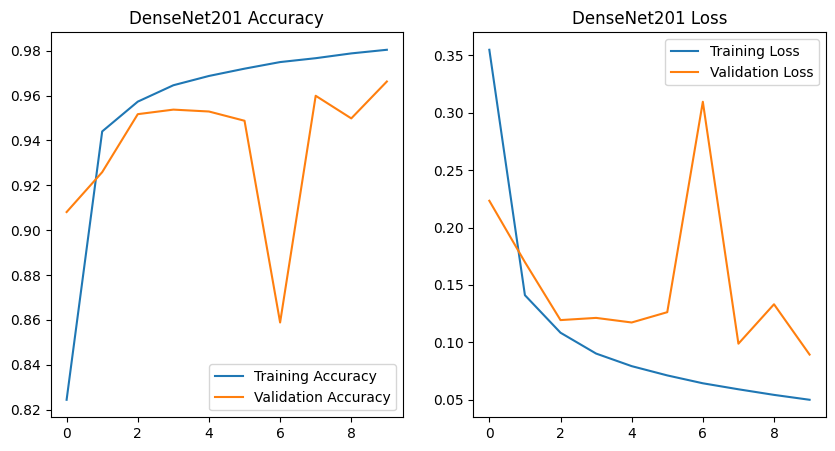

In [6]:
def train_and_evaluate(model, model_name):
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )

    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n{model_name} Test Accuracy: {test_acc}")

    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype("int32").flatten()

    print("Confusion Matrix")
    print(confusion_matrix(test_generator.classes, y_pred))

    print("Classification Report")
    print(classification_report(test_generator.classes, y_pred, target_names=['Fake', 'Real']))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()


train_and_evaluate(model, 'DenseNet201')